<a href="https://colab.research.google.com/github/ivanadu/colab/blob/main/climate_damages_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How much does the U.S. owe India for climate related damages?
First, I will consider policies around “loss and damage”, or what (if any) payments are owed by countries that have been responsible for most of the historical carbon emissions to countries that have suffered most of the damage from those emissions. How big should these payments be? In particular, how much damage have historical emissions from the U.S. caused in India, the world's most populous country with the largest number of people living below the poverty line? Answering these question will involve combining multiple data streams, utilizing output from a climate model, and computing counterfactual scenerios.

In [ ]:
#Run this cell first by hitting the play button to load packages that you'll need in this exercise
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: How much carbon has the U.S. emitted?

In this part, I will visualize historical emissions from the U.S. and the world from 1750-2020, consider how the U.S. has contributed to overall emissions, and decide from which year the U.S. should be held responsible for its emissions.

In [ ]:
# loading US emission data
us_emissions = pd.read_csv('/content/drive/My Drive/data_analysis/climate_damages/us_emissions_1750_2020.csv')

# loading world emission data
wrld_emissions = pd.read_csv('/content/drive/My Drive/data_analysis/climate_damages/wrld_emissions_1750_2020.csv')

# merging data
merged_data = pd.merge(us_emissions, wrld_emissions, on='year', how='inner')
merged_data.head()




,emitter_country,year,emissions_gtc,emissions_gtc_wrld
0,USA,1750,0.0,0.002548
1,USA,1751,0.0,0.002548
2,USA,1752,0.0,0.002549
3,USA,1753,0.0,0.002549
4,USA,1754,0.0,0.002550


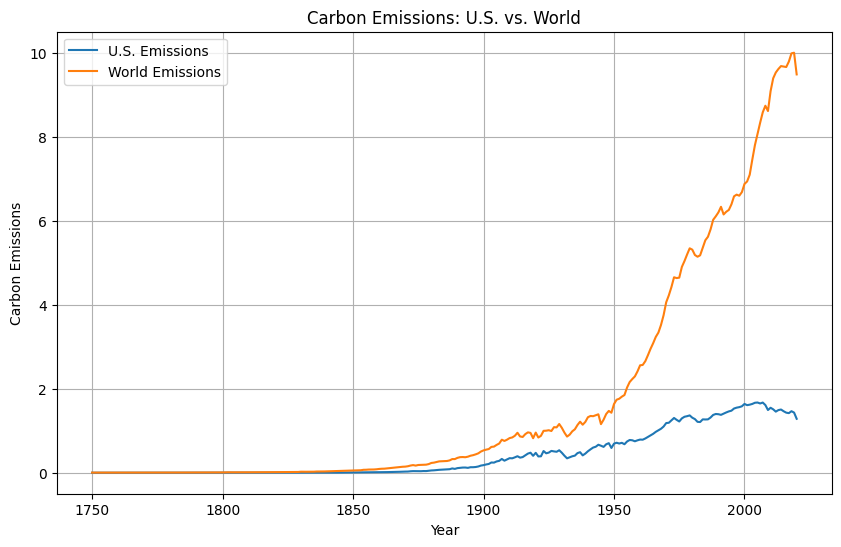

In [ ]:
# creating a graph with year on x-axis and emission on y-axis
plt.figure(figsize=(10, 6))

plt.plot(merged_data['year'], merged_data['emissions_gtc'], label='U.S. Emissions')
plt.plot(merged_data['year'], merged_data['emissions_gtc_wrld'], label='World Emissions')

plt.title('Carbon Emissions: U.S. vs. World')
plt.xlabel('Year')
plt.ylabel('Carbon Emissions')
plt.legend()

plt.grid(True)
plt.show()

The first key question I have to take a stand on is, “since when”? Are we going to hold the U.S. accountable for all of its historical emissions since the 1700s? Or just since industrial times? Or maybe just since we first knew that carbon emissions might be harmful, somewhere around 1980?  Or the first UN climate change conference in 1992? Or in 2006, the year Al Gore released “Inconvenient Truth”? I'm going to say 1980 can be the start year of holding US accountable for emissions. Because awareness is being held and people know that carbon emissions are harmful. Before that year we should not label them as the responsibles of emissions due to lacking information that emissions are harmful.

## Step 2: How much global warming did these emissions cause?
Now, I'm going to use the output of an open source “reduced complexity” climate model called FaIR. FaIR is a way to estimate how a given pulse of carbon emissions (e.g. what I emitted when I drove to work today), or how different histories of carbon emissions (e.g. US carbon emissions since 1950), have warmed the global average temperature. We used FaIR to estimate the change in “global mean surface temperature” (GMST) due to global historical emissions. We also used FaIR to estimate what the change in GMST would have been had U.S. emissions dropped to zero the year the U.S. began being responsible for its emissions. We will use the estimate of counterfactual emissions in our calculation of climate related damages.


In [ ]:
# Loading in the file `temperature_response_to_emissions_history.csv` (FaIR)

temperature_response = pd.read_csv('/content/drive/My Drive/data_analysis/climate_damages/temperature_response_to_emissions_history.csv')
temperature_response.head(5)

,temp_response,temp_response_nousa,year,damage_start_year
0,0.000001,0.000001,1770,1770
1,0.000004,0.000004,1771,1770
2,0.000010,0.000010,1772,1770
3,0.000016,0.000016,1773,1770
4,0.000023,0.000023,1774,1770


I will create a new variable in my dataframe to store the difference in the temperature response when U.S. emissions are included versus when they are excluded. Note that this difference reflects the global temperature response attributable to U.S. emissions.

In [ ]:
# new variable
difference= abs(temperature_response['temp_response']- temperature_response['temp_response_nousa'])

df = pd.read_csv('/content/drive/My Drive/data_analysis/climate_damages/temperature_response_to_emissions_history.csv')

df['difference'] = abs(df['temp_response'] - df['temp_response_nousa'])

# displaying new dataframe
df.head(5)

,temp_response,temp_response_nousa,year,damage_start_year,difference
0,0.000001,0.000001,1770,1770,0.0
1,0.000004,0.000004,1771,1770,0.0
2,0.000010,0.000010,1772,1770,0.0
3,0.000016,0.000016,1773,1770,0.0
4,0.000023,0.000023,1774,1770,0.0


FaIR is a non-linear model, so the temperature change attributed to U.S. emissions in a given year will depend on when you started "counting" U.S. emissions. For example, the temperature change in 1980 that is attributable to U.S. emissions will be larger if you started counting the impact of U.S. emissions in 1850 vs. if you started counting in 1975. This dataset contains the results of running FaIR with different start years. I will find the different start years represented in the data, and identify the start year closest to 1980 (chosen previously).  

In [ ]:

chosen_year = 1980
unique_start_years = df['damage_start_year'].unique()


In [ ]:
# Identifying start year

closest_start_year = min(unique_start_years, key=lambda x: abs(x - chosen_year))

# filtering for relevant years
filtered_df = df[df['damage_start_year'] == 2000]

filtered_df.head(5)


,temp_response,temp_response_nousa,year,damage_start_year,difference
3243,0.002078,0.001584,2000,2000,0.000494
3244,0.008901,0.006802,2001,2000,0.002099
3245,0.019253,0.014757,2002,2000,0.004496
3246,0.030969,0.023822,2003,2000,0.007147
3247,0.043642,0.033709,2004,2000,0.009932


## Step 3:  What was the effect of these emissions on temperatures in India?
FaIR gives us the global temperature change.  But warming is not uniform across the globe:  the higher latitudes warm faster than the tropics, and land warms faster than ocean.  So we next need to ask:  for a given amount of global warming, how much would we expect India to warm?  Here I are going to use an approach called “pattern scaling”, which uses information from even fancier climate models (called “general circulation models”, or GCMs) to estimate changes in a whole host of climate parameters.  I will not run these models ourselves, since they require years on a supercomputer. Instead, I'm just going to take an average value for the "warming ratio", i.e. the ratio that tells us how much India warms if the globe warms by 1 degree. To estimate total warming in India due to U.S. emissions, I need to multiply the change in global temperature due to U.S. emissions from FaIR with the average warming ratio in India.


7. First, load the data stored in the `india_data.csv` file. Then, add information from the temperature response dataframe to the India dataframe through a merge, only keeping rows that coorespond to years that are present in both datasets. Finally, create a new variable that represents the estimated temperature change in India due to U.S. emissions. After you are finished, display the first five rows of your dataset and check your work.

In [ ]:
# loading India's climate data
india = pd.read_csv('/content/drive/My Drive/data_analysis/climate_damages/india_data.csv')

# merging for only relevant years
merged_df = pd.merge(india, filtered_df, on='year')

merged_df['estimated_temp_change_india'] = merged_df['difference'] * merged_df['warming_ratio']

merged_df.head()


,country_code,year,temperature,gdp_pcap,population,warming_ratio,temp_response,temp_response_nousa,damage_start_year,difference,estimated_temp_change_india
0,IND,2000,24.847981,757.668747,1059633675,0.834365,0.002078,0.001584,2000,0.000494,0.000412
1,IND,2001,24.939831,780.606234,1078970907,0.834365,0.008901,0.006802,2000,0.002099,0.001751
2,IND,2002,25.315932,796.724786,1098313039,0.834365,0.019253,0.014757,2000,0.004496,0.003752
3,IND,2003,24.942000,845.274844,1117415123,0.834365,0.030969,0.023822,2000,0.007147,0.005964
4,IND,2004,25.107121,897.628233,1136264583,0.834365,0.043642,0.033709,2000,0.009932,0.008287


Now, I am going to estimate counterfactual temperatures in India, or what temperatures in India would have been had the U.S. had no emissions after the selected start year.

In [ ]:
# new variable to store the counterfactual India temperature

merged_df['counterfactual_temp'] = merged_df['temperature'] - merged_df['estimated_temp_change_india']
merged_df.head(5)

,country_code,year,temperature,gdp_pcap,population,warming_ratio,temp_response,temp_response_nousa,damage_start_year,difference,estimated_temp_change_india,counterfactual_temp
0,IND,2000,24.847981,757.668747,1059633675,0.834365,0.002078,0.001584,2000,0.000494,0.000412,24.847569
1,IND,2001,24.939831,780.606234,1078970907,0.834365,0.008901,0.006802,2000,0.002099,0.001751,24.938080
2,IND,2002,25.315932,796.724786,1098313039,0.834365,0.019253,0.014757,2000,0.004496,0.003752,25.312181
3,IND,2003,24.942000,845.274844,1117415123,0.834365,0.030969,0.023822,2000,0.007147,0.005964,24.936037
4,IND,2004,25.107121,897.628233,1136264583,0.834365,0.043642,0.033709,2000,0.009932,0.008287,25.098834


Now I will plot temperature vs. year for the observed temperature and for the estimated counterfactual temperature with no U.S. emissions. Year on the x-axis, temperature on the y-axis, for both observed and counterfactual temperatures.

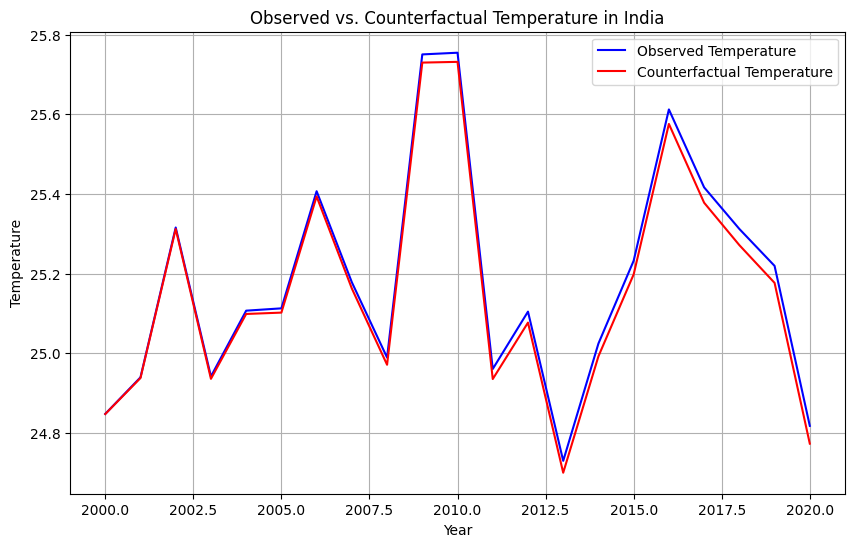

In [ ]:
# setting up plot data
plt.figure(figsize=(10, 6))
plt.plot(merged_df['year'], merged_df['temperature'], label='Observed Temperature', color='blue')
plt.plot(merged_df['year'], merged_df['counterfactual_temp'], label='Counterfactual Temperature', color='red')

# plotting labels
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Observed vs. Counterfactual Temperature in India')
plt.legend()

plt.grid(True)
plt.show()


## Step 4:  What is the economic impact of an additional degree of warming?
Now I will turn to economic data to try to understand the relationship between warming temperatures and economic output.  I'm going to use data on per capita gross domestic product (GDP) for India for over a half century, and use estimates from the literature on how past temperature changes have affected growth in GDP per capita.



The growth rate in per capita GDP in year $i$ is given by $\frac{per \ capita \ GDP_i \ - \ per \ capita \ GDP_{i-1}}{per \ capita \ GDP_{i-1}}$




Then I will combine this temperature/per-capita growth relationship with our estimates of how much cooler India would have been without US emissions to calculate the impact of US emissions on the Indian economy.


In [ ]:
# looking at observed per-capita GDP growth rate for India

merged_df['growth_gdp_pcap'] = merged_df['gdp_pcap'].pct_change()

merged_df['difference']= merged_df['difference']* merged_df['warming_ratio']


Now, I am going to compute counterfactual growth, that is what the per captia GDP would have been in India had there been no U.S. emissions after the selected start year.

In [ ]:
# create a new variable that stores the change in per-capita GDP due to U.S. emissions

merged_df['growth_impact']= merged_df['difference']*(-0.01)
merged_df.head()

,country_code,year,temperature,gdp_pcap,population,warming_ratio,temp_response,temp_response_nousa,damage_start_year,difference,estimated_temp_change_india,counterfactual_temp,growth_gdp_pcap,growth_impact
0,IND,2000,24.847981,757.668747,1059633675,0.834365,0.002078,0.001584,2000,0.000412,0.000412,24.847569,NaN,-0.000004
1,IND,2001,24.939831,780.606234,1078970907,0.834365,0.008901,0.006802,2000,0.001751,0.001751,24.938080,0.030274,-0.000018
2,IND,2002,25.315932,796.724786,1098313039,0.834365,0.019253,0.014757,2000,0.003752,0.003752,25.312181,0.020649,-0.000038
3,IND,2003,24.942000,845.274844,1117415123,0.834365,0.030969,0.023822,2000,0.005964,0.005964,24.936037,0.060937,-0.000060
4,IND,2004,25.107121,897.628233,1136264583,0.834365,0.043642,0.033709,2000,0.008287,0.008287,25.098834,0.061937,-0.000083


In [ ]:
# create a second new variable that gives the counterfactual per-capita GDP growth if there had been zero U.S. emissions

merged_df['counterfactual_growth']= merged_df['growth_gdp_pcap']- merged_df['growth_impact']


Now, I'll start to consider the effect of U.S. emissions on per capita GDP over time.

  If per capita GDP growth is 2% in year 1, then per capita GDP in year 2 can be written as $per \ capita \ GDP_{year 2}$ = 1.02 * $per \ capita \ GDP_{year 1}$.

  Also growth compounds, so if the growth in year 2 is 3%, then $per \ capita \ GDP_{year 3}$ = 1.02 * 1.03 * $per \ capita \ GDP_{year 1}$.

In [ ]:
# performing arithmetic to adjust  counterfactual growth variable so that it can be used in calculations

merged_df['counterfactual_growth']= merged_df['counterfactual_growth']+1


In [ ]:
# creating a new variable to calculate the cumulative counterfactual growth in each year

merged_df['cumulative_counterfactual_growth']=merged_df['counterfactual_growth'].cumprod()


In [ ]:
# create a variable that stores damages each year

merged_df['damages']= (merged_df['gdp_pcap'][0]*merged_df['cumulative_counterfactual_growth'])- merged_df['gdp_pcap']


## Step 5:  What does the US owe India?
Here, I will put it all together. Step 2 gave me the total amount of global warming, Step 3 translated this into country specific warming, and Step 4 told me how to translate this country specific warming into impacts on per capita GDP in each year.  Now, I want to know the total sum that the US owes India since the start year you selected in step 1.





I want to find total GDP losses in each year, which is per capita GDP losses in each year times population in that year, and then we sum across years to get the total impact.

In [ ]:
# calculating losses
merged_df['GDPlosses']= merged_df['damages']* merged_df['population']

# printing losses
useoweindia= merged_df['GDPlosses'].sum()
print(useoweindia)

71309494084.83978


# Analysis + Final Considerations

Relative to the total Indian GDP, the GDP losses due to climate change that the USA would owe India is about 2.2% of India's total GDP of about 3.176 trillion USD (2021). Thus relatively, this loss is not great though it may be argued that it is a great hit to India's economy. To take a closer look at this, it is more effective to look at the aid that the United States already provides to India. The US has provided India with approximately 65.1 billion dollars in economic aid. Though this may be less than the 71.3 billion that India is owed, relatively the difference is an extremely small amount of 0.195% ((71.3-65.1)/3176) of India's total GDP. Considering that there may be other debts that India would owe the US, this economic aid should be enough to offset the damages of climate change on India's GDP. The United States have also commited 1 billion dollars to the Green Climate Fund (GCF) which delivers climate action to 140 countries. This, I beleive is not enough as if we consider the 71.3 billion that is owed to India, it is unlikely that 1 billion will be enough to cover aid to 140 countries.

I don't think that the calculation adequately captures what the US owes for climate damages as it id difficult to know exactly where India would be in the absence of any climate related damage from the US as seen similarly in experimental design. For exmaple, the climate damages early on when aid was yet to be issued from the United States may have hindered proccesses, such as changes in infrastructure, that would have benefitted India's GDP growth. It is also important to consider the historical relationship between India and the US in which the US helped to improve India's GDP. During the times of great development of India's GDP, the US played a major role in things like trade. In considering all these factors, though this model inadequately predicts past climate damages, there is no way to predict how India's GDP would look without the US's climate damages (it is difficult to produce something like a difference in difference due to India's unique infrastructure and history). Thus, I beleive that the US should owe no more or less than what was calculated.

The Diffusion theory of change is described as being a bottom to top change in which the social norms of a population eventually influence policy change. I think presenting the findings of the potential harm of climate change on the GDP of foreign countries could present change through this theory in a country like the US. The US has a large population of immigrants with one of the highest immigration percentages in the world and from personal experience, most immigrants still care for their birth country whether out of patriotism or familial ties. Thus if made aware of the findings in this exercise, this large makeup of the US's population (immigrants) along with activists may come to care about the issue at hand, causing shifts in societal norms and more action towards this issue. From here this may follow the path up to eventual policy change.

By changing the inital year of this notebook, there would be significant changes in India's GDP loss due to climate damages by the US due to the nature of the increase of damages over time. By setting damages start date to 2010 (after 2000), the damages do not amount to nearly as much (around 10 billion), meaning that the US has well paid off their climate damages. However conversely if the damages start year was changed to 1990 (before 2000), the GDP damages amount to 380 billion. This demonstrates how the 2000s were a crucial time of change in the behaviour of the US towards climate change.